## Semantic Segmentation for Self Driving Cars
Semantic Segmentation for Self Driving Cars dataset provides data images and labeled semantic segmentations captured via CARLA self-driving car simulator. This dataset is used to train ML algorithms to identify semantic segmentation of cars, roads, obstacles etc in an image.

### Import the necessary libraries and upload the dataset.

In [36]:
import os

import tensorflow as tf

import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge

100% 5.10G/5.11G [00:56<00:00, 97.7MB/s]
100% 5.11G/5.11G [00:56<00:00, 96.8MB/s]


In [ ]:
!mkdir semantic_segmentation_dataset
!unzip lyft-udacity-challenge.zip -d semantic_segmentation_dataset

The data has 5 sets of 1000 images in RGB and corresponding semantic segments.

### Define helpful functions

Display a list of images using matplotlib.pyplot.

Parameters:
  - images: a list of images to display.
  - titles: a list of titles for each image in 'images'.
  - plot_title: main title for the plot.

In [37]:
def display_images(images, titles=None, plot_title=None, size=(15, 10), grayscale=False):
    if titles is None:
        titles = [f"Image {i + 1}" for i in range(len(images))]

    if plot_title is None:
        plot_title = "Images"

    fig, axs = plt.subplots(1, len(images), figsize=size)

    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img, cmap='gray' if grayscale else None)
        axs[i].axis('off')
        axs[i].set_title(title)

    fig.suptitle(plot_title if plot_title is not False else None, fontsize=20)
    plt.show()

Load an image from the given file path and convert it from BGR color space to RGB color space.

Parameter *im_path* is the file path of the image to be loaded.

The function returns the loaded image in RGB color space (numpy.ndarray).

In [38]:
def load_image(im_path):
    return cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB)

Create a mask from a given prediction tensor.

Parameter *pred* is a 3D or 4D tensor of predictions.

Returns a mask of the same shape as the input tensor (numpy.ndarray).

In [39]:
def create_mask(pred):
    mask = tf.argmax(pred, axis=-1)
    mask = np.array(mask[..., tf.newaxis])
    return mask

Generate masks for a list of input images using a deep learning model.

Parameters:
  - *model* - tensorflow.keras.Model
  - *images* - a list of images to generate masks for.

Returns a list of masks corresponding to the input images.

In [40]:
def get_predictions(model, images):
    pred = model.predict(images)
    pred = [create_mask(p) for p in pred]
    return pred

### Load the data from all the folders
The data is spread across 5 folders with 1000 images in each, so the dataset should contain 5000 images.

In [41]:
folders = ["A", "B", "C", "D", "E"]

image_folders = [f'semantic_segmentation_dataset/data{f}/data{f}/CameraRGB/' for f in folders]
mask_folders = [f'semantic_segmentation_dataset/data{f}/data{f}/CameraSeg/' for f in folders]

all_images = [os.path.join(folder, image) for folder in image_folders for image in os.listdir(folder)]
all_masks = [os.path.join(folder, image) for folder in mask_folders for image in os.listdir(folder)]

print("Number of images:", len(np.unique(all_images)))

assert len(all_images) == 5000

Number of images: 5000


### Form a dataset

In [42]:
image_list_ds = tf.data.Dataset.list_files(all_images, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(all_masks, shuffle=False)

full_ds = tf.data.Dataset.zip((image_list_ds, mask_list_ds))

for i, m in full_ds.take(2):
    print(i)
    print(m)

tf.Tensor(b'semantic_segmentation_dataset/dataA/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'semantic_segmentation_dataset/dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'semantic_segmentation_dataset/dataA/dataA/CameraRGB/02_00_001.png', shape=(), dtype=string)
tf.Tensor(b'semantic_segmentation_dataset/dataA/dataA/CameraSeg/02_00_001.png', shape=(), dtype=string)


### Process the data

Original resulution of the image 600x800 will be resize to 192x256.

***preprocess*** funcion takes an image and a mask as input. It resizes both the image and mask to the shape specified in IMG_SHAPE using the 'nearest' method so mask classes do not get distorted.

***process_path*** function is designed to process image and mask files given their file paths. It performs the following steps:

  - Reads the image and mask files from their respective paths.
  - Decodes the PNG-encoded images, assuming they have 3 channels (RGB).
  - Converts the image to a float32 data type (values between 0-1).
  - For the mask, it reduces the channels to a single channel by taking the maximum value along the last axis. This is common in image segmentation tasks where masks represent object boundaries.
  - Resize both the image and mask.



In [43]:
IMG_SHAPE = [192, 256]

def preprocess(image, mask):
    input_image = tf.image.resize(image, IMG_SHAPE, method='nearest')
    input_mask = tf.image.resize(mask, IMG_SHAPE, method='nearest')

    return input_image, input_mask

def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

    img, mask = preprocess(img, mask)

    return img, mask

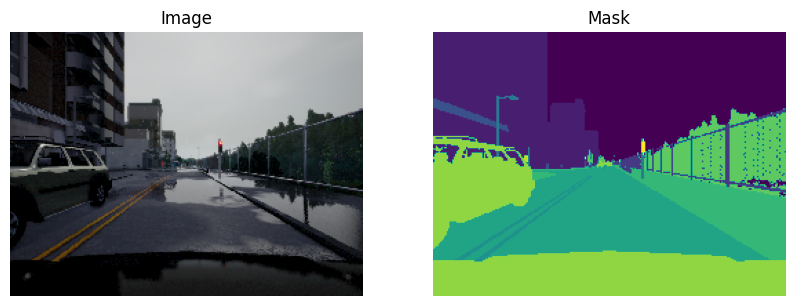

In [44]:
image_ds = full_ds.map(process_path)

for img, mask in image_ds.take(1):
    display_images([img, mask], titles=["Image", "Mask"], plot_title=False, size=(10, 10))

Let's define the number of classes

In [45]:
uniques = set()

for img, mask in image_ds.take(5000):
    uniques.update(np.unique(mask.numpy()))

print("Number of classes:", len(uniques))

Number of classes: 13


In [ ]:
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = len(uniques)

BUFFER_SIZE = 1000

### Split the data into train, val and test
70% of data (3500 images) to train the model

20% (1000 images) to validate

10% (500 images) as a test set

In [46]:
train_size = .7
val_size = .2
test_size = .1

ds_size = tf.data.experimental.cardinality(image_ds).numpy()

train_size = int(ds_size * train_size)
val_size = int(ds_size * val_size)
test_size = int(ds_size * test_size)

print("Train size:", train_size)
print("Val size:", val_size)
print("Test size:", test_size)

image_ds = image_ds.shuffle(BUFFER_SIZE)

train_ds = image_ds.take(train_size)
val_ds = image_ds.skip(train_size).take(val_size)
test_ds = image_ds.skip(train_size).skip(val_size)

Train size: 3500
Val size: 1000
Test size: 500


### Define the model

The U-Net is a popular neural network architecture commonly used for image segmentation tasks, including semantic segmentation. It is characterized by its symmetric encoder-decoder structure with skip connections.

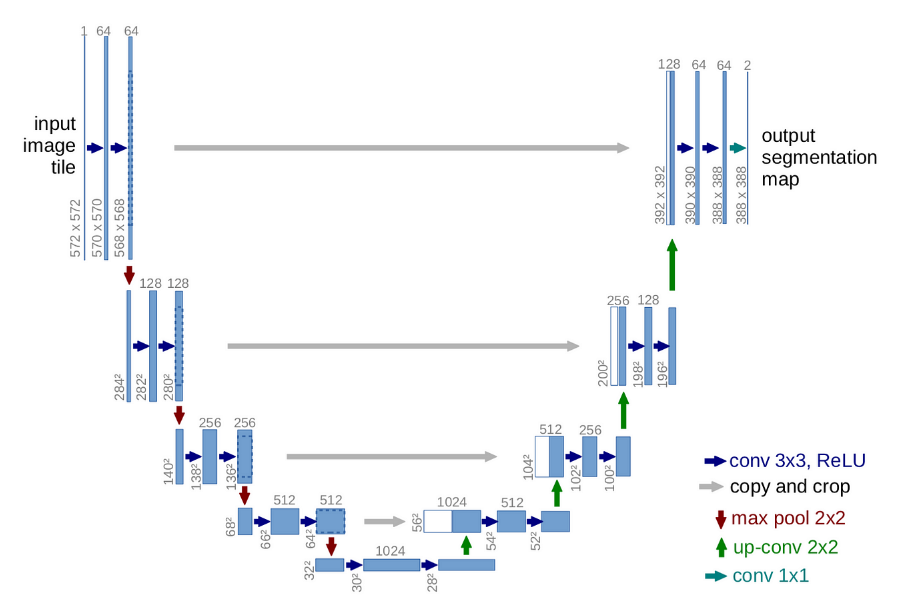

The downsample function defines a downsampling block containing of 2 convolutions. This block is used for the encoding part.

In [48]:
def downsample(filters, size, strides=(2, 2), apply_norm=True, name=None):
    # Conv2D => LeakyRelu => Conv2D => Batchnorm => LeakyRelu

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential(name=name)

    result.add(tf.keras.layers.Conv2D(filters, size, strides=strides, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.LeakyReLU())
    result.add(tf.keras.layers.Conv2D(filters, size, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_norm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

The upsample function defines an upsampling block containing a transposed convolution and a 2d convolution. This block is used for the decoding part.

In [49]:
def upsample(filters, size, strides=(2, 2), apply_dropout=False, name=None):
    # Conv2DTranspose => Batchnorm => RelU => Conv2D => Dropout => Batchnorm => Relu

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential(name=name)

    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=strides, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())
    result.add(tf.keras.layers.Conv2D(filters, size, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

Let's define the model using these functions. We will place our downsampling and upsampling blocks into lists.

Last layer is a 1D conv that outputs actual class prediction.

In [50]:
num_filters = 64

encoder = [
    downsample(num_filters,      4, apply_norm=False, name="encoder_1"),
    downsample(num_filters * 2,  4, name="encoder_2"),
    downsample(num_filters * 4,  4, name="encoder_3"),
    downsample(num_filters * 8,  4, name="encoder_4"),
    downsample(num_filters * 16, 4, name="encoder_5")
]

decoder = [
    upsample(num_filters * 8, 4, apply_dropout=True, name="decoder_1"),
    upsample(num_filters * 4, 4, apply_dropout=True, name="decoder_2"),
    upsample(num_filters * 2, 4, apply_dropout=True, name="decoder_3"),
    upsample(num_filters,     4, apply_dropout=True, name="decoder_4")
]

input_layer = tf.keras.layers.Input(shape=IMG_SHAPE + [INPUT_CHANNELS])
skips = []

x = input_layer

for down in encoder:
    x = down(x)
    skips.append(x)

skips = reversed(skips[:-1])

for up, skip in zip(decoder, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate(axis=3)([x, skip])

x = tf.keras.layers.Conv2DTranspose(32, 4, strides=2, activation='relu', padding='same', kernel_initializer='he_normal')(x)

output_layer = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 1, strides=1, padding='same')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 encoder_1 (Sequential)      (None, 96, 128, 64)          68608     ['input_2[0][0]']             
                                                                                                  
 encoder_2 (Sequential)      (None, 48, 64, 128)          393728    ['encoder_1[0][0]']           
                                                                                                  
 encoder_3 (Sequential)      (None, 24, 32, 256)          1573888   ['encoder_2[0][0]']           
                                                                                            

Visualize the model using the plot_model function from keras.utils.

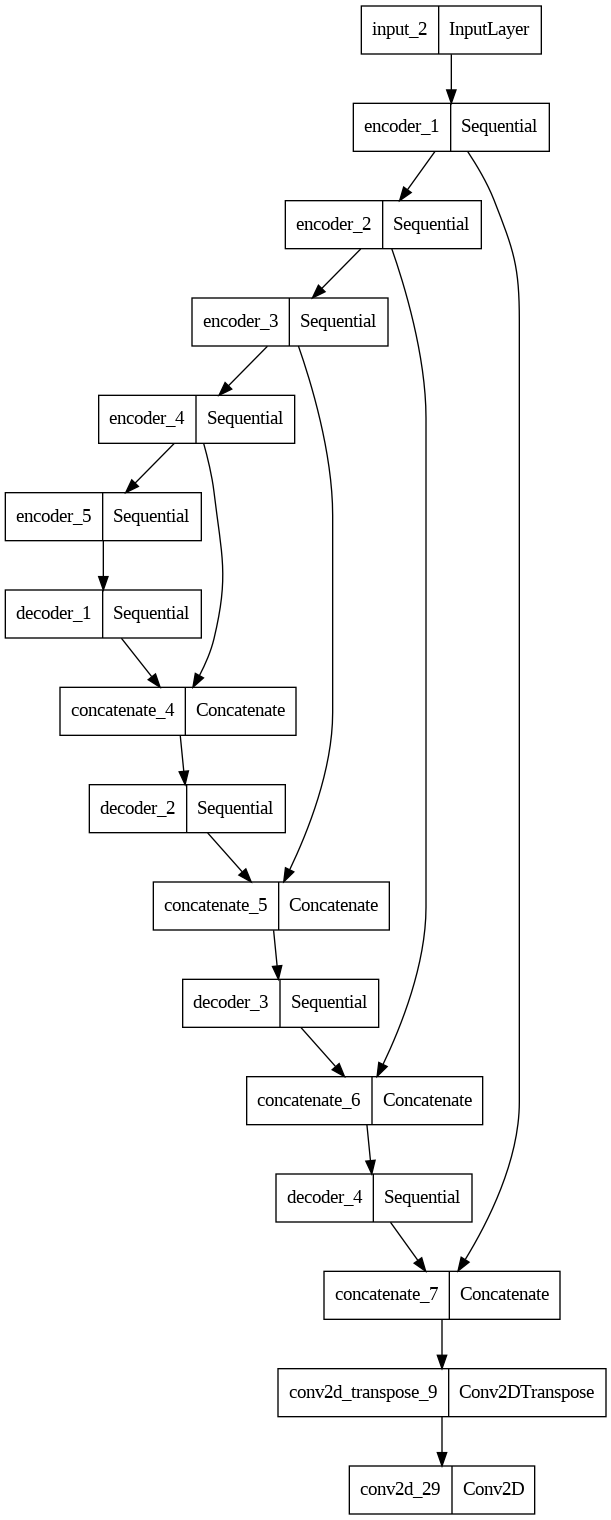

In [51]:
tf.keras.utils.plot_model(model)

### Dice coefficient

DiceMetric calculates the Dice coefficient for semantic segmentation. It measures the overlap between predicted and true segmentation masks for each class and returns the mean Dice coefficient.

The Dice similarity coefficient is computed using the following formula:

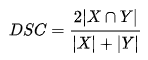

In [52]:
def DiceMetric(y_true, y_pred, smooth=1e-5):
    # Determine the number of classes in the prediction
    classes = y_pred.shape[-1]

    # Convert the true labels to one-hot encoding
    y_true = tf.cast(y_true, tf.int32)[..., -1]
    y_true = tf.one_hot(y_true, classes)

    # Apply softmax activation to the predicted values and threshold to binary
    y_pred = tf.keras.activations.softmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Calculate the intersection between true and predicted labels
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 0])
    intersection = 2 * tf.cast(intersection, tf.float32) + smooth

    # Calculate the denominator for Dice coefficient
    denominator = tf.cast(
      tf.reduce_sum(y_true, axis=[1, 2, 0]) + tf.reduce_sum(y_pred, axis=[1, 2, 0]),
      tf.float32
    ) + smooth

    # Calculate Dice coefficients for each class and then take the mean
    dice = intersection / denominator

    return tf.reduce_mean(dice, axis=-1)

### Intersection over Union metric

The Intersection over Union (IoU) metric (or Jaccard index) is another commonly used metric for evaluating the performance of semantic segmentation models.
It computes using the following formula:

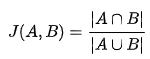

It measures the overlap between predicted and true segmentation masks for each class and returns the mean IoU, handling potential NaN values.

In [53]:
def IoU(y_true, y_pred):
    # Determine the number of classes in the prediction
    classes = y_pred.shape[-1]

    # Convert the true labels to one-hot encoding
    y_true = tf.cast(y_true, tf.int32)[..., -1]
    y_true = tf.one_hot(y_true, classes)

    # Apply softmax activation to the predicted values and threshold to binary
    y_pred = tf.keras.activations.softmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Calculate the intersection between true and predicted labels
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 0])

    # Calculate the union of true and predicted labels
    union = tf.reduce_sum(y_true, axis=[1, 2, 0]) + tf.reduce_sum(y_pred, axis=[1, 2, 0]) - intersection

    # Calculate IoU for each class and then take the mean, handling potential NaN values
    iou = intersection / union

    return tf.experimental.numpy.nanmean(iou, axis=-1)

### Compile and train the model

SparseCategoricalCrossentropy is used as a loss function, with from_logits parameter set to True, as the model outputs logits.

In [54]:
EPOCHS = 25
BATCH_SIZE = 32

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', IoU, DiceMetric]
)

Prepare the training and validation datasets:

  - Caching the training dataset for faster access.
  - Batching the cached training dataset with batch size 32.
  - Prefetching the training dataset for improved data loading performance.

In [ ]:
train_ds_b = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds_b = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

***NEpochLogger*** is a custom callback for monitoring training progress.

Output training and validation metrics at the end of each epoch.

In [55]:
class NEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs, display):
        super(NEpochLogger, self).__init__()

        self.total_epochs = total_epochs
        self.display = display
        self.current_epoch = 0


    def output(self, epoch, logs):
        line_splitter = "-" * 50

        if logs is not None:
            print("Epoch {}/{}\n{}\n{}\n{}".format(
                epoch + 1,
                self.total_epochs,
                ' - '.join([f"{k}: {v:.4f}" for k, v in logs.items() if not k.startswith("val")]),
                ' - '.join([f"{k}: {v:.4f}" for k, v in logs.items() if k.startswith("val")]),
                line_splitter
            ))


    def on_epoch_end(self, epoch, logs=None):
        self.current_epoch = epoch + 1

        if epoch == 0 or ((epoch + 1) % self.display) == 0:
            self.output(epoch, logs)


    def on_train_begin(self, logs=None):
        print("Start of training")


    def on_train_end(self, logs=None):
        if (self.current_epoch % self.display) != 0:
            self.output(self.current_epoch, logs)

        print("End of training")

EarlyStopping callback monitors validation loss and stops training if it doesn't improve for 5 consecutive epochs.

ModelCheckpoint callback saves the model's weights at the end of each epoch if validation loss improves.

NEpochLogger is custom callback to log training progress at specified intervals.

In [56]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "./unet_ep{epoch}",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    save_freq="epoch"
)
n_epoch_callback = NEpochLogger(EPOCHS, 5)

model_history = model.fit(
    train_ds_b,
    validation_data=val_ds_b,
    epochs=EPOCHS,
    callbacks=[es_callback, checkpoint_callback, n_epoch_callback],
    verbose=0
)

Started training
Epoch 1/25
loss: 0.9003 - accuracy: 0.7171 - IoU: 0.2186 - DiceMetric: 0.2532
val_loss: 10.8916 - val_accuracy: 0.6266 - val_IoU: 0.1625 - val_DiceMetric: 0.2094
--------------------------------------------------
Epoch 5/25
loss: 0.2192 - accuracy: 0.9310 - IoU: 0.4825 - DiceMetric: 0.5395
val_loss: 0.6052 - val_accuracy: 0.8399 - val_IoU: 0.3951 - val_DiceMetric: 0.4648
--------------------------------------------------
Epoch 10/25
loss: 0.1257 - accuracy: 0.9588 - IoU: 0.6318 - DiceMetric: 0.7115
val_loss: 0.1980 - val_accuracy: 0.9404 - val_IoU: 0.6132 - val_DiceMetric: 0.7054
--------------------------------------------------
Epoch 15/25
loss: 0.0980 - accuracy: 0.9670 - IoU: 0.6957 - DiceMetric: 0.7749
val_loss: 0.1744 - val_accuracy: 0.9481 - val_IoU: 0.6577 - val_DiceMetric: 0.7476
--------------------------------------------------
Epoch 20/25
loss: 0.0735 - accuracy: 0.9745 - IoU: 0.7456 - DiceMetric: 0.8149
val_loss: 0.1260 - val_accuracy: 0.9627 - val_IoU: 0.

In [57]:
print("Best epoch stats:")

best_ep_idx = np.argmin(model_history.history["val_loss"])

for metric_name, metric_history in model_history.history.items():
    print(f"{metric_name} - {metric_history[best_ep_idx]:.3f}")

Best epoch stats:
loss - 0.066
accuracy - 0.977
IoU - 0.761
DiceMetric - 0.826
val_loss - 0.099
val_accuracy - 0.970
val_IoU - 0.728
val_DiceMetric - 0.802


### Evaluate the model

Load the model from a file using the best epoch index (*best_ep_idx*) obtained during training.

Models' performance is evaluated on the test dataset.
The test dataset prepared by batching it and prefetching for efficiency.

In [60]:
model = tf.keras.models.load_model(f"./unet_ep{best_ep_idx+1}", custom_objects={"DiceMetric": DiceMetric, "IoU": IoU})

test_ds_b = test_ds.batch(16).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
model.evaluate(test_ds_b)

32/32 [==============================] - 96s 169ms/step - loss: 0.0984 - accuracy: 0.9702 - IoU: 0.7234 - DiceMetric: 0.7982


[0.09842485189437866,
 0.970173180103302,
 0.7233701348304749,
 0.7982072234153748]

The accuracy ~96-97% on the test set is not very different from that on train or val, meaning there is no overfitting.

Let's look at some images from the test dataset and generated predictions for them.

In [61]:
images = []
true_masks = []

for im, mask in test_ds.take(5):
    images.append(im.numpy())
    true_masks.append(mask.numpy())

pred = get_predictions(model, np.array(images))

1/1 [==============================] - 2s 2s/step


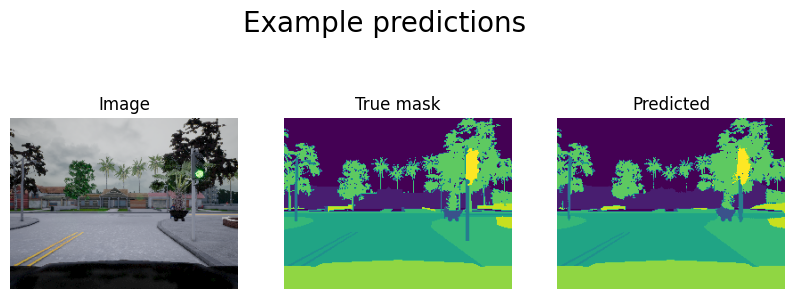

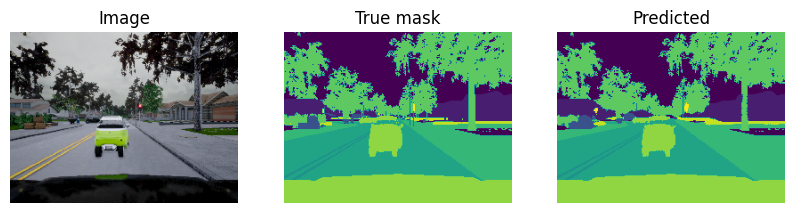

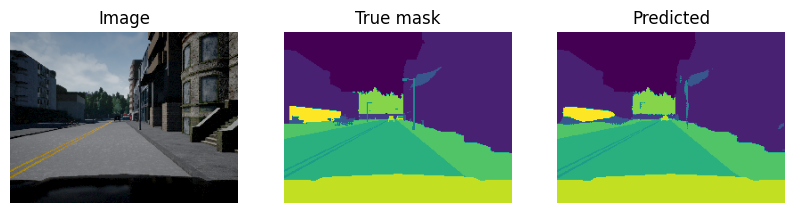

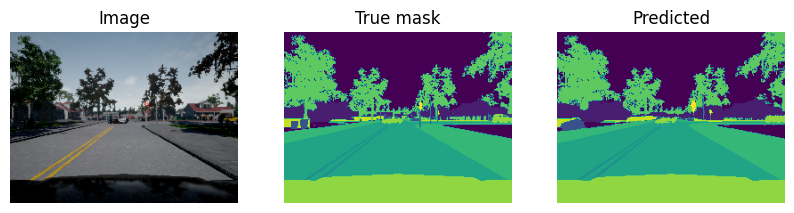

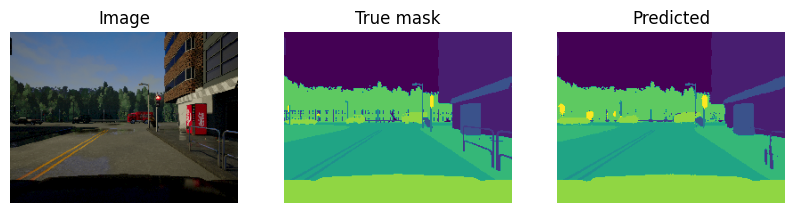

In [62]:
first = True

for im, true, pred in zip(images, true_masks, pred):
    display_images([im, true, pred], size=(10, 4), plot_title="Example predictions" if first else False, titles=("Image", "True mask", "Predicted"))
    first = False

### Save the trained model

In [63]:
filepath = "/semantic_segmentation/CARLA_UNet"
model.save(filepath)

In [64]:
!zip -r -qq "/semantic_segmentation/CARLA_UNet.zip" . -i "./semantic_segmentation_CARLA_UNet"

### Load the model weights
It is important to pass the metrics that have been used during training.

In [65]:
loaded_model = tf.keras.models.load_model(filepath, custom_objects={"DiceMetric": DiceMetric, "IoU": IoU})
loaded_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
